#### 1: Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # For quick sanity plot at the end

# Set random seed for reproducibility (important for portfolio demos)
np.random.seed(42)

print("Libraries imported successfully.")
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)

Libraries imported successfully.
NumPy version: 2.3.5
Pandas version: 2.2.2


#### 2: Parameters and Timestamp Generation

In [2]:
import numpy as np
import pandas as pd

# Simulation parameters
trading_day = '2025-06-15'          # A realistic trading day (Sunday → crypto 24/7 is fine, or change to weekday)
start_time = f'{trading_day} 00:00:00'
n_ticks = 20_000                    # ~20k ticks for one full day

# Total seconds in a trading day (24 hours for crypto; use 23400 for 6.5h equity if preferred)
total_seconds = 24 * 3600  # 86400 seconds

# Generate base regular timestamps at average interval
# We use linspace for exact control over start/end, then convert to datetime
base_times_seconds = np.linspace(0, total_seconds, n_ticks, endpoint=False)  # Start at 0, exclude endpoint

# Add realistic jitter: +/- up to 500ms (0.5 seconds) to mimic irregular arrival times
jitter_seconds = np.random.uniform(-0.5, 0.5, size=n_ticks)

# Final offsets in seconds
offsets_seconds = base_times_seconds + jitter_seconds

# Convert to timedelta and add to start
timestamps = pd.to_datetime(start_time) + pd.to_timedelta(offsets_seconds, unit='s')

# Sort to guarantee chronological order (jitter could theoretically cause tiny inversions)
timestamps = timestamps.sort_values()

# Convert to DatetimeIndex
timestamps = pd.DatetimeIndex(timestamps)

print(f"Generated {len(timestamps)} timestamps spanning one trading day.")
print("First 10 timestamps:\n", timestamps[:10])
print("\nLast 10 timestamps:\n", timestamps[-10:])
print("\nTotal time span:", timestamps[-1] - timestamps[0])
print("Min interval (ms):", (timestamps[1:] - timestamps[:-1]).min().total_seconds() * 1000)
print("Max interval (ms):", (timestamps[1:] - timestamps[:-1]).max().total_seconds() * 1000)

Generated 20000 timestamps spanning one trading day.
First 10 timestamps:
 DatetimeIndex(['2025-06-14 23:59:59.874540119',
               '2025-06-15 00:00:04.770714306',
               '2025-06-15 00:00:08.871993942',
               '2025-06-15 00:00:13.058658484',
               '2025-06-15 00:00:16.936018640',
               '2025-06-15 00:00:21.255994520',
               '2025-06-15 00:00:25.478083612',
               '2025-06-15 00:00:30.606176146',
               '2025-06-15 00:00:34.661115012',
               '2025-06-15 00:00:39.088072578'],
              dtype='datetime64[ns]', freq=None)

Last 10 timestamps:
 DatetimeIndex(['2025-06-15 23:59:16.874578247',
               '2025-06-15 23:59:21.379323569',
               '2025-06-15 23:59:25.029515700',
               '2025-06-15 23:59:29.752664226',
               '2025-06-15 23:59:34.481038498',
               '2025-06-15 23:59:38.777038629',
               '2025-06-15 23:59:42.266813957',
               '2025-06-15 23:59:46.8

#### 3: Simulate Realistic Price Path (Geometric Brownian Motion)

In [3]:
# GBM parameters: drift (mu), volatility (sigma), initial price
S0 = 60000.0    # Starting price, e.g., Bitcoin-like level
mu = 0.00005    # Small positive daily drift (~4% annualized)
sigma = 0.003   # Daily volatility (~100% annualized, typical for crypto)
dt = 1 / (252 * 24 * 3600)  # Time increment normalized to trading year (approx)

# Simulate log returns and prices
log_returns = np.random.normal(mu * dt, sigma * np.sqrt(dt), n_ticks)
log_returns[0] = 0  # No return on first tick
prices = S0 * np.exp(np.cumsum(log_returns))

# Round to realistic tick size (e.g., 0.01 for fiat pairs)
prices = np.round(prices, 2)

print("Price simulation complete.")
print("First 10 prices:", prices[:10])
print("Last 10 prices:", prices[-10:])
print(f"Final price: ${prices[-1]:,.2f} (started at ${S0:,.0f})")
print("Min/Max price:", prices.min(), prices.max())

Price simulation complete.
First 10 prices: [60000.   60000.02 60000.07 60000.03 60000.09 60000.09 60000.05 60000.08
 60000.06 60000.06]
Last 10 prices: [59995.43 59995.42 59995.41 59995.42 59995.44 59995.39 59995.38 59995.31
 59995.3  59995.31]
Final price: $59,995.31 (started at $60,000)
Min/Max price: 59994.9 60004.69


#### 4: Generate Volume and Introduce Realistic Noise/Errors

In [4]:
# Volume: Base on lognormal distribution (heavy-tailed, realistic for trades)
base_volume = np.random.lognormal(mean=8.0, sigma=1.5, size=n_ticks)  # Mean ~2980, heavy tail

# Increase volume on larger price moves (realistic market behavior)
price_changes = np.abs(np.diff(prices, prepend=prices[0])) / prices
volume_multiplier = 1 + 5 * price_changes  # Larger moves → higher volume
volumes = base_volume * volume_multiplier

# Round and clip to non-negative (keep as float for now to allow NaN later)
volumes = np.round(volumes, 0)
volumes = np.clip(volumes, 0, None)

# --- Introduce realistic errors ---

# 1. Missing values (~0.5% NaN in price and volume - feed drops)
nan_indices = np.random.choice(n_ticks, size=int(0.005 * n_ticks), replace=False)
prices[nan_indices] = np.nan
volumes[nan_indices] = np.nan  # Now safe because volumes is float

# 2. Outliers/glitches (0.1% extreme prices - flash crashes or data errors)
outlier_indices = np.random.choice(n_ticks, size=int(0.001 * n_ticks), replace=False)
# Multiply by 10x or 100x randomly
prices[outlier_indices] = prices[outlier_indices] * np.random.choice([10, 100], size=len(outlier_indices))

# 3. Negative prices (rare encoding errors)
neg_indices = np.random.choice(n_ticks, size=20, replace=False)
prices[neg_indices] = -np.abs(prices[neg_indices])

# 4. Zero volumes (low liquidity periods or no trades)
zero_vol_indices = np.random.choice(n_ticks, size=int(0.02 * n_ticks), replace=False)
volumes[zero_vol_indices] = 0.0

# 5. Duplicates (retransmissions from exchange)
dup_indices = np.random.choice(n_ticks - 100, size=50, replace=False)  # Avoid edge
# Insert duplicates
prices = np.insert(prices, dup_indices, prices[dup_indices])
volumes = np.insert(volumes, dup_indices, volumes[dup_indices])
timestamps = np.insert(timestamps.values, dup_indices, timestamps[dup_indices])  # .values to avoid index issues

# Convert timestamps back to DatetimeIndex after insertion
timestamps = pd.DatetimeIndex(timestamps)

print("Noise and errors introduced successfully.")
print(f"Total ticks after duplicates: {len(prices)}")
print(f"Missing prices: {np.isnan(prices).sum()}")
print(f"Missing volumes: {np.isnan(volumes).sum()}")
print(f"Negative prices: {(prices < 0).sum()}")
print(f"Zero volumes: {(volumes == 0).sum()}")
print(f"Duplicate timestamps: {len(timestamps) - len(np.unique(timestamps))}")

Noise and errors introduced successfully.
Total ticks after duplicates: 20050
Missing prices: 101
Missing volumes: 99
Negative prices: 20
Zero volumes: 400
Duplicate timestamps: 50


#### 5: Assemble DataFrame, Sanity Checks, Plot, and Save

In [5]:
import matplotlib.pyplot as plt

# Quick verification
print(f"Lengths after noise/duplicate introduction:")
print(f"timestamps: {len(timestamps)}")
print(f"prices:     {len(prices)}")
print(f"volumes:    {len(volumes)}")

Lengths after noise/duplicate introduction:
timestamps: 20050
prices:     20050
volumes:    20050


In [6]:
# Assemble the DataFrame
data = {
    'timestamp': timestamps,
    'symbol':    'BTCUSDT',
    'exchange':  'Binance',
    'price':     prices,
    'volume':    volumes
}

df = pd.DataFrame(data)

# Sort by timestamp to guarantee chronological order (important after jitter + duplicates)
df = df.sort_values('timestamp').reset_index(drop=True)

In [7]:
# Final sanity checks
print("\n" + "="*50)
print("FINAL SYNTHETIC DATASET SUMMARY")
print("="*50)
print(df.info())
print("\nFirst 10 rows:")
print(df.head(10))


FINAL SYNTHETIC DATASET SUMMARY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  20050 non-null  datetime64[ns]
 1   symbol     20050 non-null  object        
 2   exchange   20050 non-null  object        
 3   price      19949 non-null  float64       
 4   volume     19951 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 783.3+ KB
None

First 10 rows:
                      timestamp   symbol exchange     price  volume
0 2025-06-14 23:59:59.874540119  BTCUSDT  Binance  60000.00  7007.0
1 2025-06-15 00:00:04.770714306  BTCUSDT  Binance  60000.02  3756.0
2 2025-06-15 00:00:08.871993942  BTCUSDT  Binance  60000.07  6784.0
3 2025-06-15 00:00:13.058658484  BTCUSDT  Binance  60000.03  3287.0
4 2025-06-15 00:00:16.936018640  BTCUSDT  Binance  60000.09  1082.0
5 2025-06-15 00:00:21.255994

In [8]:
print("\nLast 10 rows:")
print(df.tail(10))


Last 10 rows:
                          timestamp   symbol exchange     price   volume
20040 2025-06-15 23:59:16.874578247  BTCUSDT  Binance  59995.43  20669.0
20041 2025-06-15 23:59:21.379323569  BTCUSDT  Binance  59995.42   1056.0
20042 2025-06-15 23:59:25.029515700  BTCUSDT  Binance  59995.41   5374.0
20043 2025-06-15 23:59:29.752664226  BTCUSDT  Binance  59995.42  40491.0
20044 2025-06-15 23:59:34.481038498  BTCUSDT  Binance  59995.44   9182.0
20045 2025-06-15 23:59:38.777038629  BTCUSDT  Binance  59995.39    940.0
20046 2025-06-15 23:59:42.266813957  BTCUSDT  Binance  59995.38   3471.0
20047 2025-06-15 23:59:46.843698469  BTCUSDT  Binance  59995.31   3933.0
20048 2025-06-15 23:59:51.303320006  BTCUSDT  Binance  59995.30   7756.0
20049 2025-06-15 23:59:55.352264814  BTCUSDT  Binance  59995.31   3161.0


In [9]:
print("\nDescriptive statistics (price & volume):")
print(df[['price', 'volume']].describe())


Descriptive statistics (price & volume):
              price         volume
count  1.994900e+04   19951.000000
mean   6.421181e+04    8805.766478
std    1.576325e+05   21599.853576
min   -6.000385e+04       0.000000
25%    5.999959e+04    1022.000000
50%    6.000132e+04    2915.000000
75%    6.000271e+04    8086.500000
max    6.000421e+06  820832.000000


In [10]:
print("\nData quality issues summary:")
print(f"Total rows:                  {len(df):,}")
print(f"Missing prices:              {df['price'].isna().sum():,}")
print(f"Missing volumes:             {df['volume'].isna().sum():,}")
print(f"Negative prices:             {(df['price'] < 0).sum():,}")
print(f"Zero volumes:                {(df['volume'] == 0).sum():,}")
print(f"Duplicate timestamps:        {df['timestamp'].duplicated().sum():,}")


Data quality issues summary:
Total rows:                  20,050
Missing prices:              101
Missing volumes:             99
Negative prices:             20
Zero volumes:                400
Duplicate timestamps:        50


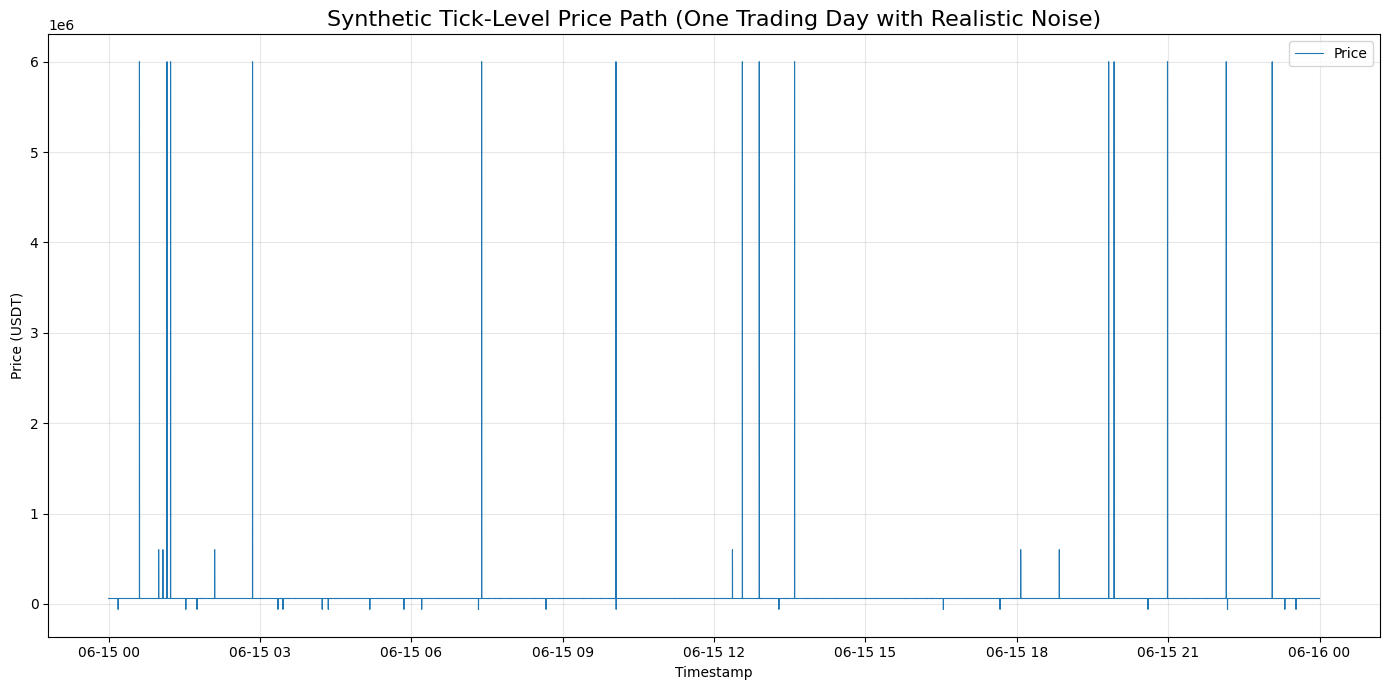

In [11]:
# Visual sanity check: Price time series
plt.figure(figsize=(14, 7))
plt.plot(df['timestamp'], df['price'], label='Price', linewidth=0.8)
plt.title('Synthetic Tick-Level Price Path (One Trading Day with Realistic Noise)', fontsize=16)
plt.xlabel('Timestamp')
plt.ylabel('Price (USDT)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

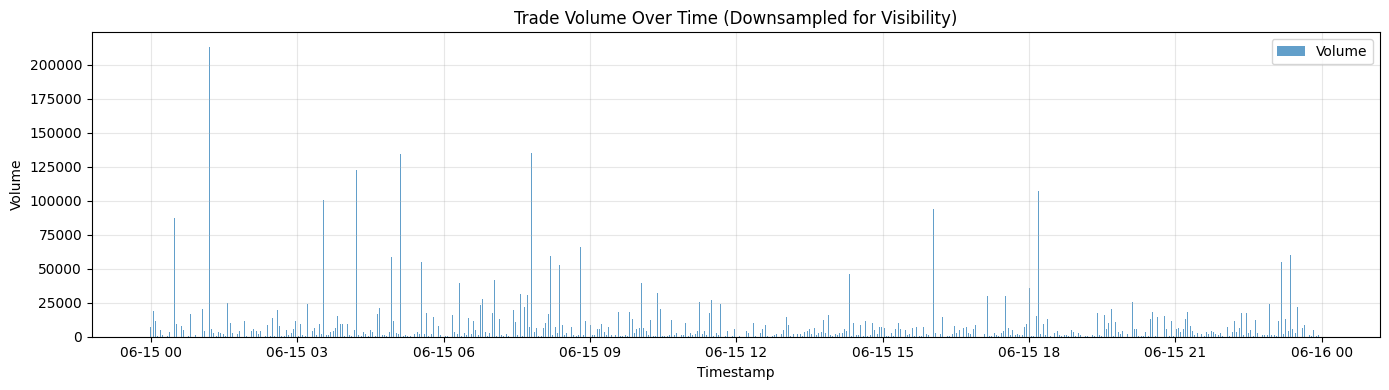

In [12]:
plt.figure(figsize=(14, 4))
# Downsample to 500 points for readable volume plot
df_sample = df.iloc[::max(1, len(df)//500)]
plt.bar(df_sample['timestamp'], df_sample['volume'], width=0.0008, alpha=0.7, label='Volume')
plt.title('Trade Volume Over Time (Downsampled for Visibility)')
plt.xlabel('Timestamp')
plt.ylabel('Volume')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Save the final messy dataset
output_path = 'synthetic_tick_data.csv'
df.to_csv(output_path, index=False)
print(f"\nSynthetic dataset successfully saved to '{output_path}' with {len(df):,} rows.")
print("This file is intentionally noisy and will be used to demonstrate data validation,")


Synthetic dataset successfully saved to 'synthetic_tick_data.csv' with 20,050 rows.
This file is intentionally noisy and will be used to demonstrate data validation,
